Note: Due to technical challenges related to my personal device compatibility, the data visualization using maps will be conducted on Jupyter Notebook within the Microsoft Windows environment. This decision arises from issues encountered with R Studio and Jupyter Notebook on MacOS. This adjustment ensures a smooth and effective execution of the data visualization process.

# Data visualisation (MAP)
### London's AirBnB and Rentals data 

In [1]:
# !pip install geopandas

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pylab as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.colors import n_colors
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline
sns.set_context("paper", font_scale = 2)
sns.axes_style({ 'xtick.direction': 'out', 'ytick.direction': 'out',})
sns.set_style("darkgrid")

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Load data

In [3]:
# Define the file path
Airbnb_path = 'm:/pc/desktop/Project/Airbnb_Focus.csv'
Rental_path = 'm:/pc/desktop/Project/Rental_Price.csv'
Housing_path = 'm:/pc/desktop/Project/Housing_price.csv'

# Load the CSV file into a Pandas DataFrame
Airbnb_df = pd.read_csv(Airbnb_path)
Rental_df = pd.read_csv(Rental_path)
Housing_df = pd.read_csv(Housing_path)

In [4]:
# Define the GeoJSON file path
geojson_path = 'm:/pc/desktop/Project/neighbourhoods.geojson'
# Load the GeoJSON file into a GeoPandas GeoDataFrame
neighbourhoods_gdf = gpd.read_file(geojson_path)

In [5]:
# Display the first few rows of the DataFrame
print(Airbnb_df.head())

                Borough Bedroom.Category  Count_of_listing  Mean  \
0  Barking and Dagenham        1 Bedroom                60    67   
1  Barking and Dagenham       2 Bedrooms                30   134   
2  Barking and Dagenham       3 Bedrooms                 0   139   
3  Barking and Dagenham           Studio                 0    90   
4                Barnet        1 Bedroom               180    79   

   Lower_quartile  Median  Upper_quartile  Annual_OCC  
0              39      56              94   26.889873  
1             102     125             180   23.067101  
2             124     152             152   22.270553  
3              90      90              90   10.655738  
4              47      68              96   28.392099  


In [6]:
print(Rental_df.head())

                Borough Bedroom.Category  Count.of.rents  Mean  \
0  Barking and Dagenham           Studio              10   779   
1  Barking and Dagenham        1 Bedroom             200  1046   
2  Barking and Dagenham       2 Bedrooms             340  1266   
3  Barking and Dagenham       3 Bedrooms             240  1505   
4                Barnet           Studio             110   962   

   Lower.quartile  Median  Upper.quartile  
0             750     750             850  
1             950    1050            1100  
2            1200    1250            1350  
3            1400    1500            1600  
4             850     950            1050  


In [7]:
Airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Borough           125 non-null    object 
 1   Bedroom.Category  125 non-null    object 
 2   Count_of_listing  125 non-null    int64  
 3   Mean              125 non-null    int64  
 4   Lower_quartile    125 non-null    int64  
 5   Median            125 non-null    int64  
 6   Upper_quartile    125 non-null    int64  
 7   Annual_OCC        125 non-null    float64
dtypes: float64(1), int64(5), object(2)
memory usage: 7.9+ KB


In [8]:
Rental_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Borough           131 non-null    object
 1   Bedroom.Category  131 non-null    object
 2   Count.of.rents    131 non-null    int64 
 3   Mean              131 non-null    int64 
 4   Lower.quartile    131 non-null    int64 
 5   Median            131 non-null    int64 
 6   Upper.quartile    131 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 7.3+ KB


In [9]:
neighbourhoods_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   neighbourhood        33 non-null     object  
 1   neighbourhood_group  0 non-null      object  
 2   geometry             33 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 920.0+ bytes


neighbourhood_group is full of NaNs. So we can probably get rid of those columns. We can check what other columns are completely full of NaNs.

In [10]:
def get_nan_columns(df):
    """
        Return the column names where all their data is NaN from a dataframe
    """
    nan_cols = []
    for col in df.columns:
        if df[col].isna().all():
            nan_cols.append(col)
    return nan_cols

In [11]:
neighbourhood_nans = get_nan_columns(neighbourhoods_gdf)
print(f"{neighbourhood_nans}")

['neighbourhood_group']


In [12]:
neighbourhoods_gdf.drop(neighbourhood_nans, inplace=True, axis=1)
neighbourhoods_gdf = neighbourhoods_gdf.set_index("neighbourhood")

Add statistics data to the neighbourhood_gdf 

In [13]:
neighbourhoods_gdf["Airbnb_price"] = Airbnb_df.groupby("Borough")["Mean"].mean().round(2)
neighbourhoods_gdf["Rental_price"] = Rental_df.groupby("Borough")["Mean"].mean().round(2)
neighbourhoods_gdf["Airbnb_count"] = Airbnb_df.groupby("Borough")["Count_of_listing"].sum()
neighbourhoods_gdf["Rental_count"] = Rental_df.groupby("Borough")["Count.of.rents"].sum()
neighbourhoods_gdf["Airbnb_Annual_OCC"] = Airbnb_df.groupby("Borough")["Annual_OCC"].mean().round(2)
neighbourhoods_gdf.head()

,geometry,Airbnb_price,Rental_price,Airbnb_count,Rental_count,Airbnb_Annual_OCC
neighbourhood,,,,,,
Kingston upon Thames,"MULTIPOLYGON (((-0.33066 51.32901, -0.33057 51...",137.33,1375.50,80,610,42.19
Croydon,"MULTIPOLYGON (((-0.06399 51.31864, -0.06405 51...",82.50,1173.75,220,1450,34.74
Bromley,"MULTIPOLYGON (((0.01216 51.29960, 0.01199 51.2...",106.33,1264.75,100,2260,30.79
Hounslow,"MULTIPOLYGON (((-0.24454 51.48870, -0.24466 51...",122.75,1362.50,140,1310,33.32
Ealing,"MULTIPOLYGON (((-0.41181 51.53408, -0.41186 51...",117.00,1455.00,270,1610,35.79


In [14]:
neighbourhoods_gdf["centre"] = neighbourhoods_gdf["geometry"].centroid;

C:\Users\st22712\AppData\Local\Temp\ipykernel_10636\2267409707.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  neighbourhoods_gdf["centre"] = neighbourhoods_gdf["geometry"].centroid;


#### Plot multiple column maps

In [15]:
def plot_multiple_column_maps(df, column_list, cmap_label_list, cmap_roundoff=1, annotate=True, savefig=False, savefig_path=None):
    """
        Plot multiple columns from a GeoPandas DataFrame
    """

    n_cols = len(column_list)
    _, axes = plt.subplots(ncols=n_cols, figsize=(25, 12), sharey=True)
    
    for i, col in enumerate(column_list):
        df.plot(
            ax=axes[i],
            column=col, 
            figsize=(15, 12), 
            alpha=0.9, 
            edgecolor='grey', 
            legend=True, 
            cmap="BuPu",
            vmin=np.round(df[col].min(), cmap_roundoff),
            vmax=np.round(df[col].max(), cmap_roundoff),
            legend_kwds={'label': cmap_label_list[i], 'orientation': "horizontal"},
        )
        axes[i].set_axis_off()
        plt.margins(y=0)
        
        if annotate:
            for _, row in df.iterrows():
                axes[i].annotate(
                    text=int(row[col]), 
                    xy=(row["centre"].x,row["centre"].y), 
                    horizontalalignment='center', 
                    fontsize=10,
                    weight="bold",
                )
                 
    if savefig:
        if savefig_path is None:
            savefig_path = f"{col}_map.png"
        plt.savefig(savefig_path, dpi=800)
        print(f"Figure saved to {savefig_path}")

    plt.show()

Plot mean price

Figure saved to m:/pc/desktop/Project/Price_vs_map.png


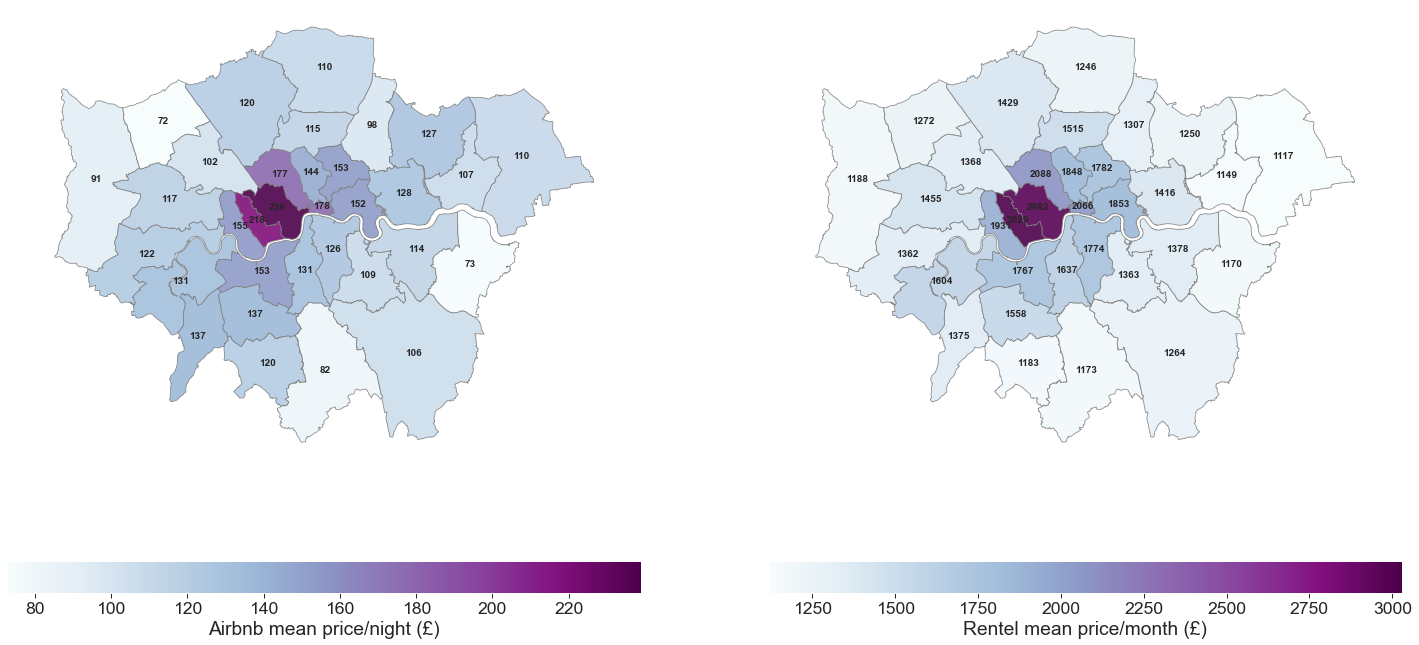

In [16]:
plot_multiple_column_maps(neighbourhoods_gdf, ["Airbnb_price", "Rental_price"], ["Airbnb mean price/night (£)", "Rentel mean price/month (£)"], savefig=True, savefig_path="m:/pc/desktop/Project/Price_vs_map.png")

Plot the count of listings/rentals

Figure saved to m:/pc/desktop/Project/Count_vs_map.png


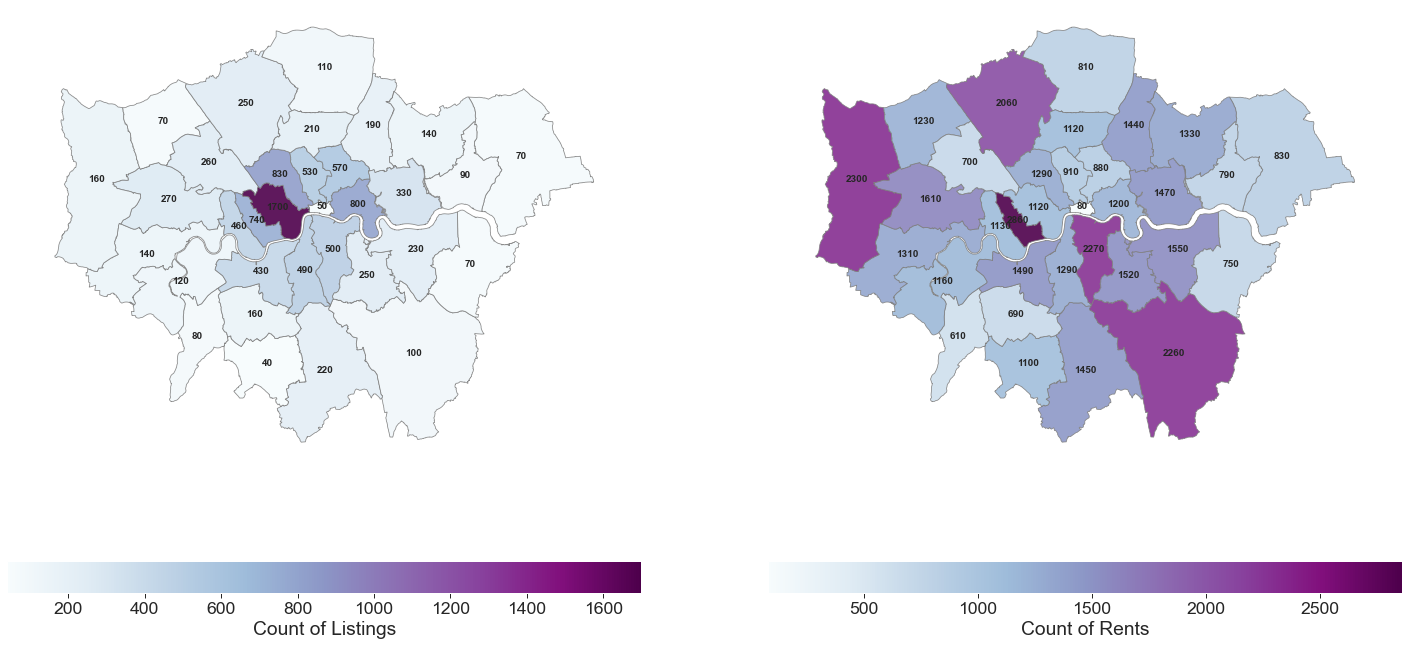

In [17]:
plot_multiple_column_maps(neighbourhoods_gdf, ["Airbnb_count", "Rental_count"], ["Count of Listings", "Count of Rents"], savefig=True, savefig_path="m:/pc/desktop/Project/Count_vs_map.png")

In [18]:
def print_topN_price(df, column_name, top_n=5):
    """
        Returns top n values of a column_name from a DataFrame
        Input:
            df: pandas dataframe 
            column_name: name of column that we want to use in function
            top_n: number of top results we want from column_name
        Output:
            printed statements  
    """    
    print(f"\nLondon's most expensive boroughs, form {column_name}, are:")

    for i in range(top_n):
        print(f"\t{df[column_name].nlargest(top_n).index.to_numpy()[i]}: £ {np.round(df[column_name].nlargest(top_n).values[i], 2)}")

In [19]:
print_topN_price(neighbourhoods_gdf, "Airbnb_price")
print_topN_price(neighbourhoods_gdf, "Rental_price")


London's most expensive boroughs, form Airbnb_price, are:
	Westminster: £ 239.0
	Kensington and Chelsea: £ 218.75
	City of London: £ 178.0
	Camden: £ 177.5
	Hammersmith and Fulham: £ 155.0

London's most expensive boroughs, form Rental_price, are:
	Kensington and Chelsea: £ 3029.75
	Westminster: £ 2982.25
	Camden: £ 2088.5
	City of London: £ 2066.33
	Hammersmith and Fulham: £ 1931.0


In [20]:
def print_topN(df, column_name, top_n=5):
    
    print(f"\nLondon's boroughs highest ,  {column_name}, are:")

    for i in range(top_n):
        print(f"\t{df[column_name].nlargest(top_n).index.to_numpy()[i]}: {np.round(df[column_name].nlargest(top_n).values[i], 0)} units ")

In [21]:
print_topN(neighbourhoods_gdf, "Airbnb_count")
print_topN(neighbourhoods_gdf, "Rental_count")


London's boroughs highest ,  Airbnb_count, are:
	Westminster: 1700 units 
	Camden: 830 units 
	Tower Hamlets: 800 units 
	Kensington and Chelsea: 740 units 
	Hackney: 570 units 

London's boroughs highest ,  Rental_count, are:
	Kensington and Chelsea: 2860 units 
	Hillingdon: 2300 units 
	Southwark: 2270 units 
	Bromley: 2260 units 
	Barnet: 2060 units 


#### Plot single column map

In [22]:
def plot_single_column_maps(df, column_name, cmap_label, roundoff=1, annotate=True, savefig=False, savefig_path=None):
    """
    Plot a single column from a GeoPandas DataFrame
    """

    _, axes = plt.subplots(ncols=1, figsize=(15, 12), sharey=True)

    df.plot(
        ax=axes,
        column=column_name, 
        figsize=(15, 12), 
        alpha=0.9, 
        edgecolor='grey', 
        legend=True, 
        cmap="BuPu",
        vmin=np.round(df[column_name].min(), roundoff),
        vmax=np.round(df[column_name].max(), roundoff),
        legend_kwds={'label': cmap_label, 'orientation': "horizontal"},
    )
    axes.set_axis_off()
    plt.margins(y=0)
    
    if annotate:
        for _, row in df.iterrows():
            axes.annotate(
                text=np.round(row[column_name], roundoff), 
                xy=(row["centre"].x, row["centre"].y), 
                horizontalalignment='center', 
                fontsize=10,
                weight="bold",
            )
    
    if savefig:
        if savefig_path is None:
            savefig_path = f"{column_name}_map.png"
        plt.savefig(savefig_path, dpi=600)
        print(f"Figure saved to {savefig_path}")

    plt.show()


Figure saved to m:/pc/desktop/Project/Airbnb_price_map.png


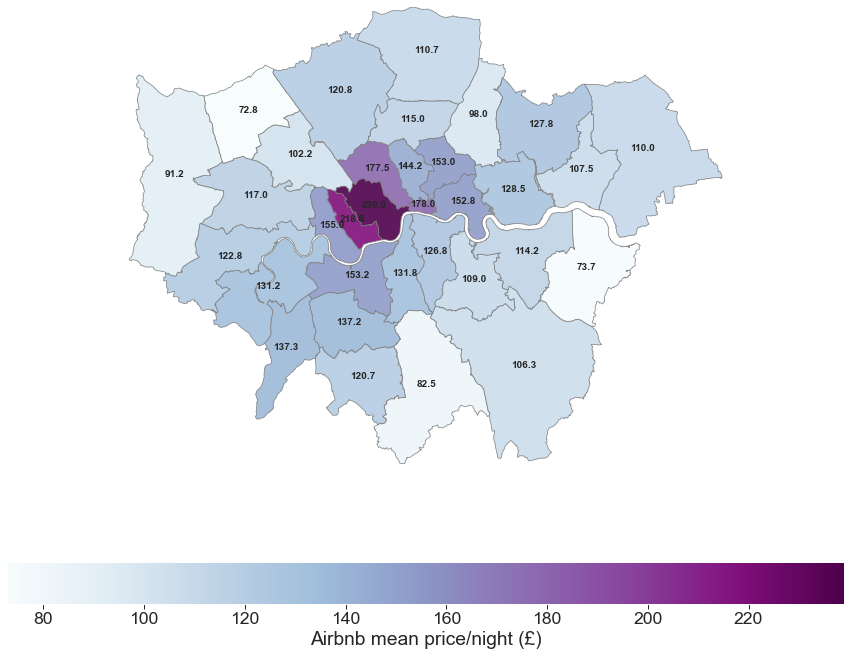

In [23]:
plot_single_column_maps(neighbourhoods_gdf, "Airbnb_price", "Airbnb mean price/night (£)", savefig=True, savefig_path="m:/pc/desktop/Project/Airbnb_price_map.png")

Figure saved to m:/pc/desktop/Project/Rental_price_map.png


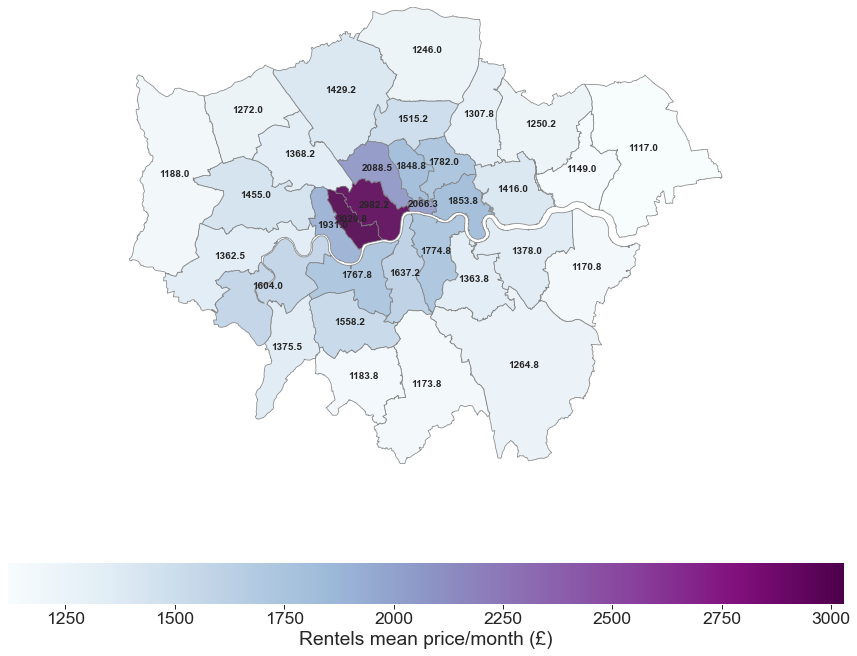

In [24]:
plot_single_column_maps(neighbourhoods_gdf, "Rental_price", "Rentels mean price/month (£)", savefig=True, savefig_path="m:/pc/desktop/Project/Rental_price_map.png")

Figure saved to m:/pc/desktop/Project/ABNB_OCC_map.png


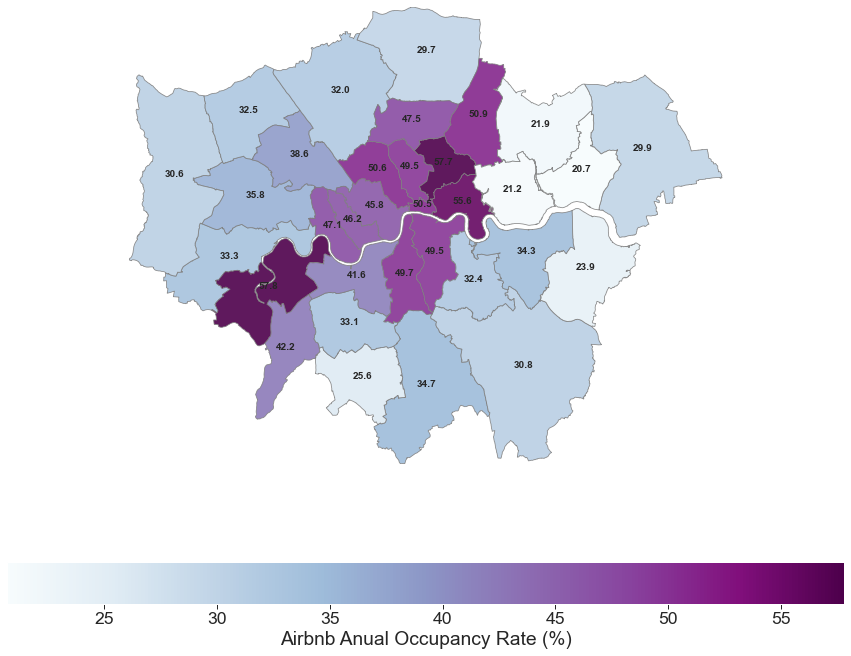

In [25]:
plot_single_column_maps(neighbourhoods_gdf, "Airbnb_Annual_OCC", "Airbnb Anual Occupancy Rate (%)", savefig=True, savefig_path="m:/pc/desktop/Project/ABNB_OCC_map.png")

In [26]:
print_topN(neighbourhoods_gdf, "Airbnb_Annual_OCC")


London's boroughs highest ,  Airbnb_Annual_OCC, are:
	Richmond upon Thames: 58.0 units 
	Hackney: 58.0 units 
	Tower Hamlets: 56.0 units 
	Waltham Forest: 51.0 units 
	Camden: 51.0 units 


Figure saved to m:/pc/desktop/Project/OOC_Count_vs_map.png


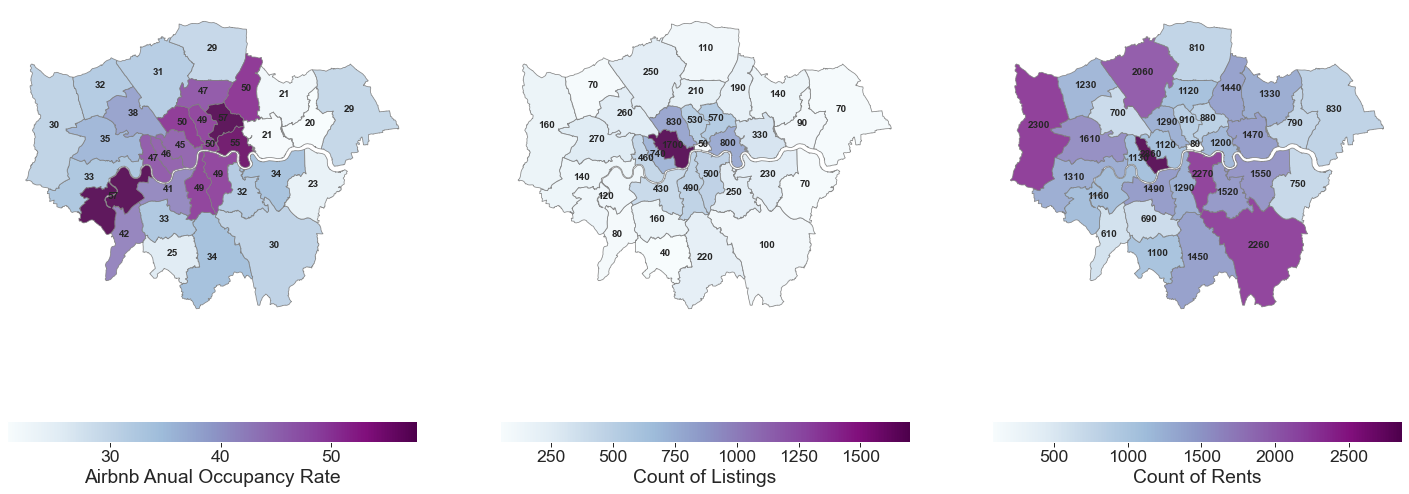

In [27]:
plot_multiple_column_maps(neighbourhoods_gdf, ["Airbnb_Annual_OCC","Airbnb_count", "Rental_count"], ["Airbnb Anual Occupancy Rate","Count of Listings", "Count of Rents"], savefig=True, savefig_path="m:/pc/desktop/Project/OOC_Count_vs_map.png")

### Gross rental yeild

Calculate and add gross rental yield column  

In [28]:
# Get Average Property_value of each Borough form Housing_df
neighbourhoods_gdf["Property_value"] = Housing_df.groupby("Borough")["Flat_price"].sum()

# Calculate the annual income 
neighbourhoods_gdf["Rental_Annual_Income"] = neighbourhoods_gdf["Rental_price"] * 12
neighbourhoods_gdf["ABNB_Annual_Income"] = (neighbourhoods_gdf["Airbnb_price"] * 365 * (neighbourhoods_gdf["Airbnb_Annual_OCC"] / 100)).round()

# Calculate the gross rental yield
neighbourhoods_gdf["Rental_GRYield"] = ((neighbourhoods_gdf["Rental_Annual_Income"] / neighbourhoods_gdf["Property_value"]) * 100).round(2)
neighbourhoods_gdf["ABNB_GRYield"] = ((neighbourhoods_gdf["ABNB_Annual_Income"] / neighbourhoods_gdf["Property_value"]) * 100).round(2)

In [29]:
neighbourhoods_gdf.head()

,geometry,Airbnb_price,Rental_price,Airbnb_count,Rental_count,Airbnb_Annual_OCC,centre,Property_value,Rental_Annual_Income,ABNB_Annual_Income,Rental_GRYield,ABNB_GRYield
neighbourhood,,,,,,,,,,,,
Kingston upon Thames,"MULTIPOLYGON (((-0.33066 51.32901, -0.33057 51...",137.33,1375.50,80,610,42.19,POINT (-0.28688 51.38791),381125,16506.0,21148.0,4.33,5.55
Croydon,"MULTIPOLYGON (((-0.06399 51.31864, -0.06405 51...",82.50,1173.75,220,1450,34.74,POINT (-0.08713 51.35533),291465,14085.0,10461.0,4.83,3.59
Bromley,"MULTIPOLYGON (((0.01216 51.29960, 0.01199 51.2...",106.33,1264.75,100,2260,30.79,POINT (0.05155 51.37200),349412,15177.0,11950.0,4.34,3.42
Hounslow,"MULTIPOLYGON (((-0.24454 51.48870, -0.24466 51...",122.75,1362.50,140,1310,33.32,POINT (-0.36710 51.46838),318945,16350.0,14929.0,5.13,4.68
Ealing,"MULTIPOLYGON (((-0.41181 51.53408, -0.41186 51...",117.00,1455.00,270,1610,35.79,POINT (-0.33100 51.52248),371377,17460.0,15284.0,4.70,4.12


Figure saved to m:/pc/desktop/Project/GRY_vs_map.png


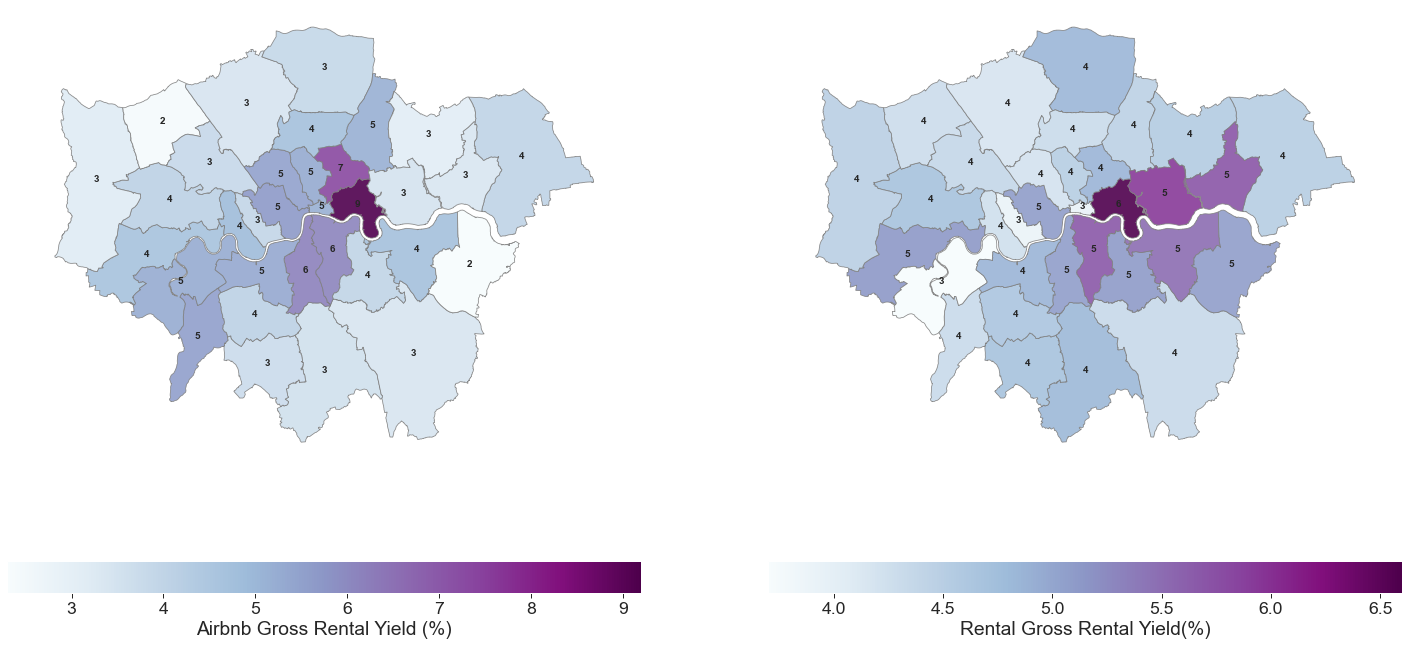

In [30]:
plot_multiple_column_maps(neighbourhoods_gdf, ["ABNB_GRYield", "Rental_GRYield"], ["Airbnb Gross Rental Yield (%)", "Rental Gross Rental Yield(%)"], savefig=True, savefig_path="m:/pc/desktop/Project/GRY_vs_map.png")

In [31]:
print_topN(neighbourhoods_gdf, "ABNB_GRYield")
print_topN(neighbourhoods_gdf, "Rental_GRYield")


London's boroughs highest ,  ABNB_GRYield, are:
	Tower Hamlets: 9.0 units 
	Hackney: 7.0 units 
	Lambeth: 6.0 units 
	Southwark: 6.0 units 
	Westminster: 6.0 units 

London's boroughs highest ,  Rental_GRYield, are:
	Tower Hamlets: 7.0 units 
	Newham: 6.0 units 
	Barking and Dagenham: 6.0 units 
	Southwark: 6.0 units 
	Greenwich: 5.0 units 


### Return of Investment (RoI)

**RoI = (Net Profit) / (Initial Investment) * 100** 
 
Where:
- **Net Profit** is calculated as the difference between Rental Income and the sum of Operating Expenses and Mortgage Payments.
- **Initial Investment** comprises the down payment, closing costs, and other associated expenses, if applicable.

*In this scenario*, we assume that the expenses for both Short-Term Rental (STR) and Long-Term Rental (LTR) are expressed as a percentage of the Annual Rental Income. Specifically, we consider STR expenses to be 50%, and LTR expenses to be 40%. Additionally, it is assumed that both STR and LTR have the same Initial Investment. This Initial Investment includes a down payment equivalent to 30% of the property value and closing costs plus other expenses accounting for 10%.


In [32]:
# Calculate the Net profit
neighbourhoods_gdf["Rental_Net_Profit"] = neighbourhoods_gdf["Rental_Annual_Income"] * 0.6
neighbourhoods_gdf["ABNB_Net_Profit"] = neighbourhoods_gdf["ABNB_Annual_Income"] * 0.5

# Calculate the Net Initial Investment
neighbourhoods_gdf["Initial_Investment"] = neighbourhoods_gdf["Property_value"] * (0.3 + 0.1)

# Calculate the Return of Investment
neighbourhoods_gdf["Rental_RoI"] = ((neighbourhoods_gdf["Rental_Net_Profit"] / neighbourhoods_gdf["Initial_Investment"]) * 100)
neighbourhoods_gdf["ABNB_RoI"] = ((neighbourhoods_gdf["ABNB_Net_Profit"] / neighbourhoods_gdf["Initial_Investment"]) * 100)

In [33]:
neighbourhoods_gdf.head()

,geometry,Airbnb_price,Rental_price,Airbnb_count,Rental_count,Airbnb_Annual_OCC,centre,Property_value,Rental_Annual_Income,ABNB_Annual_Income,Rental_GRYield,ABNB_GRYield,Rental_Net_Profit,ABNB_Net_Profit,Initial_Investment,Rental_RoI,ABNB_RoI
neighbourhood,,,,,,,,,,,,,,,,,
Kingston upon Thames,"MULTIPOLYGON (((-0.33066 51.32901, -0.33057 51...",137.33,1375.50,80,610,42.19,POINT (-0.28688 51.38791),381125,16506.0,21148.0,4.33,5.55,9903.6,10574.0,152450.0,6.496294,6.936045
Croydon,"MULTIPOLYGON (((-0.06399 51.31864, -0.06405 51...",82.50,1173.75,220,1450,34.74,POINT (-0.08713 51.35533),291465,14085.0,10461.0,4.83,3.59,8451.0,5230.5,116586.0,7.248726,4.486388
Bromley,"MULTIPOLYGON (((0.01216 51.29960, 0.01199 51.2...",106.33,1264.75,100,2260,30.79,POINT (0.05155 51.37200),349412,15177.0,11950.0,4.34,3.42,9106.2,5975.0,139764.8,6.515374,4.275039
Hounslow,"MULTIPOLYGON (((-0.24454 51.48870, -0.24466 51...",122.75,1362.50,140,1310,33.32,POINT (-0.36710 51.46838),318945,16350.0,14929.0,5.13,4.68,9810.0,7464.5,127578.0,7.689414,5.850930
Ealing,"MULTIPOLYGON (((-0.41181 51.53408, -0.41186 51...",117.00,1455.00,270,1610,35.79,POINT (-0.33100 51.52248),371377,17460.0,15284.0,4.70,4.12,10476.0,7642.0,148550.8,7.052133,5.144368


Figure saved to m:/pc/desktop/Project/RoI_vs_map.png


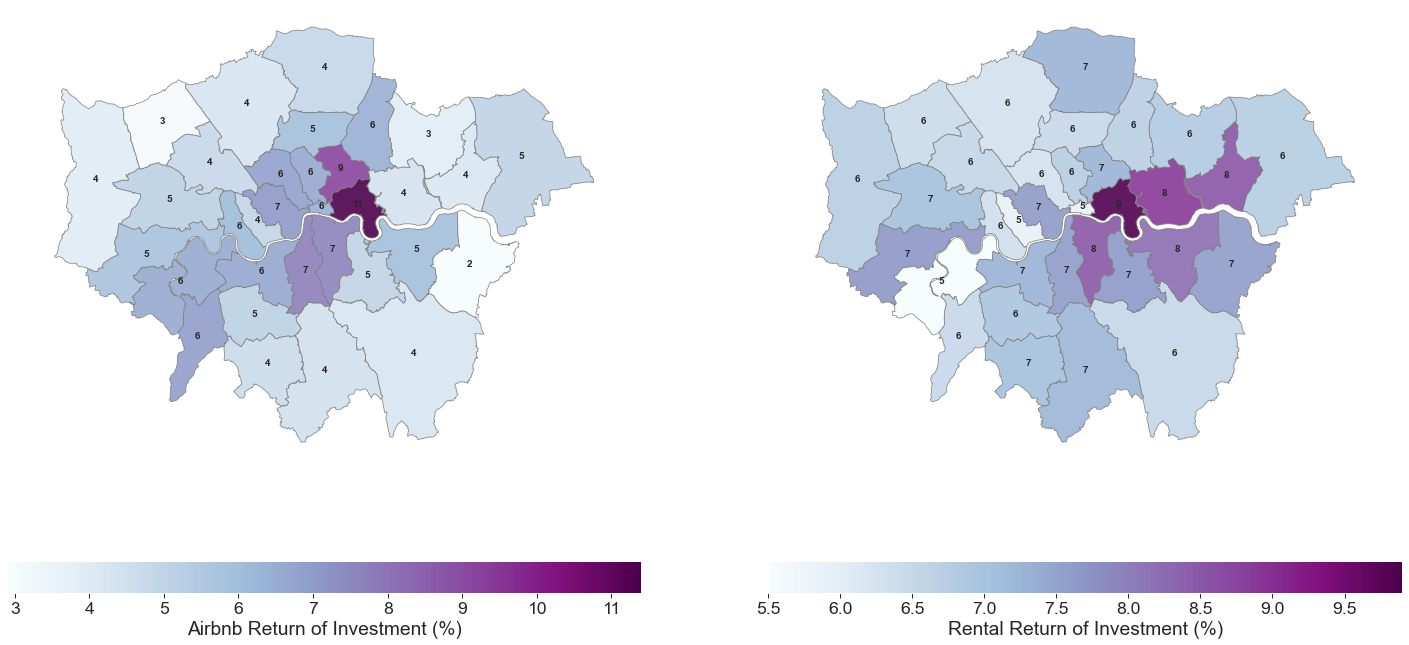

In [34]:
plot_multiple_column_maps(neighbourhoods_gdf, ["ABNB_RoI", "Rental_RoI"], ["Airbnb Return of Investment (%)", "Rental Return of Investment (%)"], savefig=True, savefig_path="m:/pc/desktop/Project/RoI_vs_map.png")

In [35]:
print_topN(neighbourhoods_gdf,"ABNB_RoI")
print_topN(neighbourhoods_gdf,"Rental_RoI")


London's boroughs highest ,  ABNB_RoI, are:
	Tower Hamlets: 11.0 units 
	Hackney: 9.0 units 
	Lambeth: 8.0 units 
	Southwark: 8.0 units 
	Westminster: 7.0 units 

London's boroughs highest ,  Rental_RoI, are:
	Tower Hamlets: 10.0 units 
	Newham: 9.0 units 
	Barking and Dagenham: 9.0 units 
	Southwark: 9.0 units 
	Greenwich: 8.0 units 
